In [ ]:
import itertools
import matplotlib.pyplot as plt
import multiprocessing
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import logging

from dataclasses import dataclass
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from typing import *

In [ ]:
import sys, os
a_path = os.path.abspath(os.path.join(os.getcwd(), '.', 'python_generated'))
# insert it at front so imports find it first
sys.path.insert(0, a_path)
import message_pb2

In [ ]:
N = 5_000
SEED: int = 2025
GAMMA = '1.8'

@dataclass(frozen=True)
class Files:
  states: str
  network: str
  genetic: str
  experiment: str

file_map = {
  '1.6': Files(
    states='data/drug-v0129d-N5k-gamma1.6-10drugs/derived/states-1769778787192.csv',
    network='data/drug-v0129d-N5k-gamma1.6-10drugs/derived/networks-1769778787192.csv',
    genetic='data/random-forests/retention-vs-accuracy-v0129d-N5k-gamma1.6-10drugs-genetic-combined.csv',
    experiment='data/drug-v0129d-N5k-gamma1.6-10drugs/raw/experiment-1769740895784-a59f2ec0-b437-471c-8561-b22fc7f82c65.pb',
  ),
  '1.8': Files(
    states='data/drug-v0129d-N5k-gamma1.8-10drugs/derived/states-1769778862662.csv',
    network='data/drug-v0129d-N5k-gamma1.8-10drugs/derived/networks-1769778862662.csv',
    genetic='data/random-forests/retention-vs-accuracy-v0129d-N5k-gamma1.8-10drugs-genetic-combined.csv',
    experiment='data/drug-v0129d-N5k-gamma1.8-10drugs/raw/experiment-1769740825354-8f662dd8-ec4c-499a-b64b-352073c5c66a.pb',
  ),
  '2.0': Files(
    states='data/drug-power-law-phase-transition-max-drug-strength/derived/states-1752795739394.csv',
    network='data/drug-power-law-phase-transition-max-drug-strength/derived/networks-1752795739394.csv',
    genetic='data/random-forests/retention-vs-accuracy-v1217d-N5k-10drugs-genetic-combined.csv',
    experiment='data/drug-power-law-phase-transition-max-drug-strength/raw/experiment-1752795708188-6beadaee-7c68-4549-9570-9ce48dd4b5cf.pb',
  ),
}

STATES_FILE: Final[str] = file_map[GAMMA].states
NETWORK_FILE: Final[str] = file_map[GAMMA].network
GENETIC_ALGORITHM_RESULTS_FILE: Final[str] = file_map[GAMMA].genetic
EXPERIMENT_FILE: Final[str] = file_map[GAMMA].experiment


In [ ]:
states_df = pd.read_csv(STATES_FILE)
network_df = pd.read_csv(NETWORK_FILE)
feature_df = pd.read_csv(GENETIC_ALGORITHM_RESULTS_FILE)

In [ ]:
experiment = message_pb2.Experiment()
# Read the existing address book.
with open(EXPERIMENT_FILE, 'rb') as f:
  experiment.ParseFromString(f.read())

In [ ]:
df = states_df.copy().reset_index(drop=True)
node_cols = [f'node-{i}' for i in range(N)]

df['rep'] = (df.index.to_numpy() % 10).astype(np.int64)
df = df.set_index(['original_network_idx', 'initial_condition_idx', 'rep'], drop=False)

X = df[node_cols].to_numpy(dtype=np.float64, copy=False)

is_control = (df['drug_name'] == 'control').to_numpy()
controls_mat = pd.DataFrame(X[is_control], index=df.index[is_control], columns=node_cols)

treated_idx = df.index[~is_control]
treated_mat = pd.DataFrame(X[~is_control], index=treated_idx, columns=node_cols)

aligned_controls = controls_mat.reindex(treated_mat.index)

missing = aligned_controls.isna().any(axis=1)
if missing.any():
  bad = aligned_controls.index[missing].tolist()[:10]
  raise KeyError(f'Missing control for {missing.sum()} treated keys. Example keys: {bad}')

diff = aligned_controls.to_numpy() - treated_mat.to_numpy()
a = treated_idx.get_level_values(0).to_numpy(np.int64)
b = treated_idx.get_level_values(1).to_numpy(np.int64)
c = treated_idx.get_level_values(2).to_numpy(np.int64)

A = np.zeros((50, 10, 10, N), dtype=np.float64)
A[a, b, c, :] = np.abs(diff)
B = A.mean(axis=2).mean(axis=1)

In [ ]:
data = []
for max_num_features in 2 ** np.arange(0, 8):
  for original_network_idx in range(50):
    nodes_strs = list(eval(feature_df[(feature_df.original_network_idx == original_network_idx) & (feature_df.max_num_features==max_num_features)].features.iloc[0]))
    node_idxs = [int(node_str.split('-')[1]) for node_str in nodes_strs]
    data.append({
      'type': 'selected',
      'original_network_idx': original_network_idx,
      'node_idxs': node_idxs,
      'max_num_features': max_num_features,
      'dist': B[original_network_idx][node_idxs].mean(),
    })
    data.append({
      'type': 'not-selected',
      'original_network_idx': original_network_idx,
      'node_idxs': node_idxs,
      'max_num_features': max_num_features,
      'dist': np.delete(B[original_network_idx], node_idxs).mean(),
    })

selected_df = pd.DataFrame(data)

In [ ]:
_df = selected_df[(selected_df.max_num_features == 16) & (selected_df['type'] == 'not-selected')]
c = 1.96
CUTOFF = _df.dist.mean() + c * _df.dist.std() / np.sqrt(len(_df))
CUTOFF

np.float64(0.21965528227689568)

In [ ]:
data = []
fine_grained_selected_data = []
for max_num_features in 2 ** np.arange(0, 8):
  for original_network_idx in range(50):
    nodes_strs = list(eval(feature_df[(feature_df.original_network_idx == original_network_idx) & (feature_df.max_num_features==max_num_features)].features.iloc[0]))
    node_idxs = [int(node_str.split('-')[1]) for node_str in nodes_strs]
    for node_idx in node_idxs:
      fine_grained_selected_data.append({
        'original_network_idx': original_network_idx,
        'node_idx': node_idx,
        'max_num_features': max_num_features,
        'dist': B[original_network_idx][node_idx].squeeze(),
        'above-cutoff?': B[original_network_idx][node_idx].squeeze() > CUTOFF,
      })

fine_grained_selected_df = pd.DataFrame(fine_grained_selected_data)

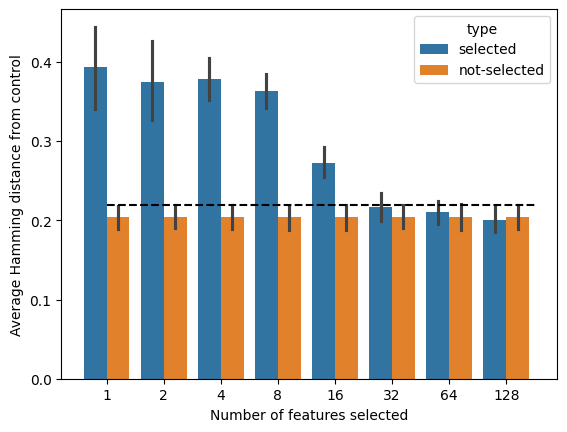

In [ ]:
sns.barplot(
  data=selected_df,
  x='max_num_features',
  y='dist',
  hue='type',
).set(
  xlabel='Number of features selected',
  ylabel='Average Hamming distance from control',
)
plt.hlines(CUTOFF, 0, 7.5, colors='black', linestyles='--')

In [ ]:
PCT_ABOVE_CUTOFF = (B > CUTOFF).mean()
PCT_ABOVE_CUTOFF

np.float64(0.409536)

In [ ]:
hamming_distances_df = pd.DataFrame(B.T).melt(var_name='original_network_idx', value_name='dist')
# hamming_distances_df

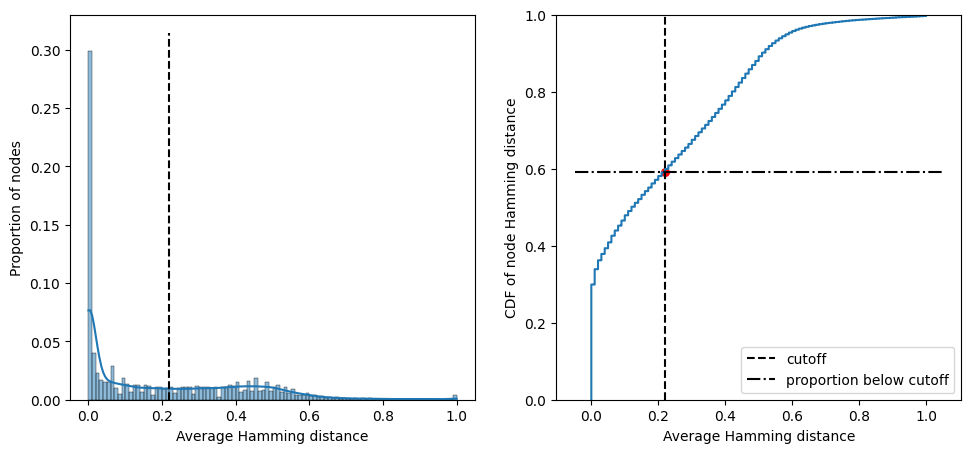

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=5*np.array([2.3, 1.]))
g = sns.histplot(
  data=hamming_distances_df,
  x='dist',
  bins=100,
  kde=True,
  stat='proportion',
  ax=axes[0],
)

g.set(
  xlabel='Average Hamming distance',
  ylabel='Proportion of nodes',
)

g.vlines(CUTOFF, 0, g.get_ylim()[1], linestyles='--', colors='black', label='cutoff')

h = sns.ecdfplot(
  data=hamming_distances_df,
  x='dist',
  ax=axes[1],
)
h.set(
  xlabel='Average Hamming distance',
  ylabel='CDF of node Hamming distance',
)

h.vlines(CUTOFF, 0, h.get_ylim()[1], linestyles='--', colors='black', label='cutoff')
h.hlines(1-PCT_ABOVE_CUTOFF, h.get_xlim()[0], h.get_xlim()[1], linestyles='-.', colors='black', label='proportion below cutoff')
h.scatter([CUTOFF], [1-PCT_ABOVE_CUTOFF], s=30, marker='o', c='red')

plt.legend()

In [ ]:
randomly_selected_data = []
for max_num_features in 2 ** np.arange(0, 8):
  for original_network_idx in range(50):
    for initial_condition_idx in range(1):
      node_idxs = np.random.choice(N, size=max_num_features, replace=False)
      for node_idx in node_idxs:
        randomly_selected_data.append({
          'original_network_idx': original_network_idx,
          'max_num_features': max_num_features,
          # 'initial_condition_idx': initial_condition_idx,
          'node_idx': node_idx,
          'dist': B[original_network_idx][node_idx].squeeze(),
          'above-cutoff?': B[original_network_idx][node_idx].squeeze() > CUTOFF,
        })

randomly_selected_df = pd.DataFrame(randomly_selected_data)

In [ ]:
combined_selected_df = pd.concat([
  randomly_selected_df.assign(selection_method='random'),
  fine_grained_selected_df.assign(selection_method='genetic'),
])

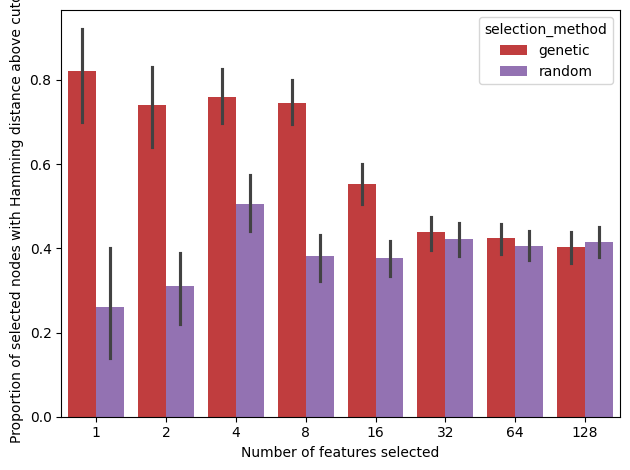

In [ ]:
palette = sns.color_palette('tab10', n_colors=5)
ax = sns.barplot(
  data=combined_selected_df.groupby(['selection_method', 'max_num_features', 'original_network_idx'])['above-cutoff?'].mean().reset_index(),
  x='max_num_features',
  y='above-cutoff?',
  hue='selection_method',
  # hue='above-cutoff?',
  palette=[palette[3], palette[4]],
  # hue_order=[True, False],
)

ax.set(
  xlabel='Number of features selected',
  ylabel='Proportion of selected nodes with Hamming distance above cutoff',
  # yscale='log',
)
plt.tight_layout()

In [ ]:
palette = sns.color_palette('tab10', n_colors=5)
def proportion_side_cutoff(side: Literal['above'] | Literal['below']):
  filter = combined_selected_df['above-cutoff?'] == (side == 'above')
  ax = sns.boxplot(
    data=combined_selected_df[filter],#.groupby(['selection_method', 'max_num_features', 'original_network_idx'])['dist'].mean().reset_index(),
    x='max_num_features',
    y='dist',
    hue='selection_method',
    # hue='above-cutoff?',
    palette=[palette[3], palette[4]],
    hue_order=['genetic', 'random'],
    legend=True,
    #split=True,
    showmeans=True,
    # meanline=True,
    meanprops={'marker':'s','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'},
  )

  ax.set(
    xlabel='Number of features selected',
    ylabel=f'Average Hamming distance of selected nodes {side} cutoff',
    #yscale='log',
  )

  _ddf = combined_selected_df[filter & (combined_selected_df['selection_method'] == 'genetic')]
  sns.lineplot(
    data=_ddf,
    x=np.log2(_ddf['max_num_features'])-.25,
    y='dist',
    ax=ax,
    c=palette[3],
  )
  _ddf = combined_selected_df[filter & (combined_selected_df['selection_method'] == 'random')]
  sns.lineplot(
    data=_ddf,
    x=np.log2(_ddf['max_num_features'])+.25,
    y='dist',
    ax=ax,
    c=palette[4],
  )

  ax.hlines(CUTOFF, -0.5, 7.5, colors='black', linestyles='--', label='cutoff')

  ax.legend(title='Selection method', loc='lower right')
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1+.02))
  return ax

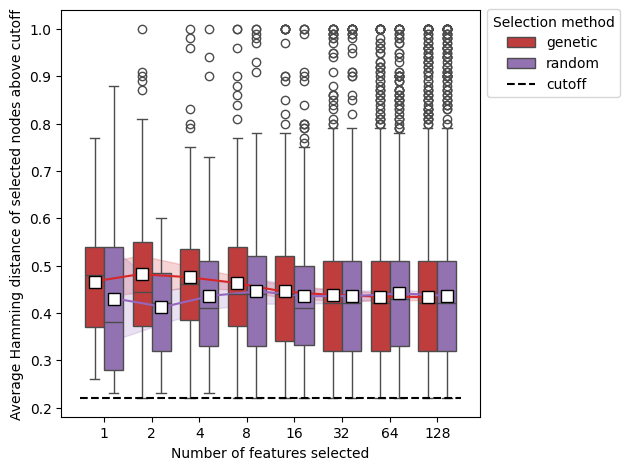

In [ ]:
proportion_side_cutoff('above')
plt.tight_layout()

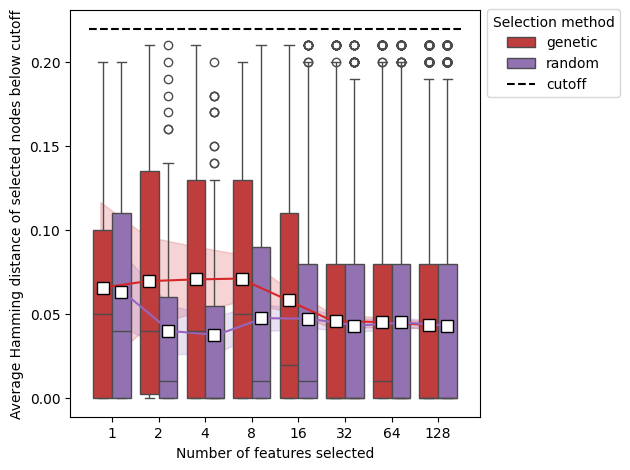

In [ ]:
proportion_side_cutoff('below')
plt.tight_layout()

In [ ]:
def get_extracted_nodes(selection_method: Literal['random'] | Literal['genetic'], max_num_features: int):
  activity_nodes = combined_selected_df.groupby('original_network_idx').apply(lambda _df: _df[
      (_df.max_num_features == max_num_features)
    & (_df['above-cutoff?'] == True)
    & (_df.selection_method == selection_method)
  ], include_groups=False)
  extracted_nodes = 'node-' + activity_nodes.node_idx.astype(str)
  return extracted_nodes, activity_nodes

In [ ]:
Gs = [nx.DiGraph() for _ in range(50)]
for original_network_idx, G in enumerate(Gs):
  _df = network_df[
    (network_df.original_network_idx == original_network_idx)
  ]
  Gs[original_network_idx] = nx.from_pandas_edgelist(_df, edge_attr=['weight'], create_using=nx.DiGraph)
  G.add_nodes_from(range(N))

undirected_Gs = [G.to_undirected() for G in Gs]

In [ ]:
from collections import deque

In [ ]:
def sample_shortest_path(original_network_idx, source, target):
  if nx.shortest_path_length(undirected_Gs[original_network_idx], source, target) != 2: return None
  mids = set(Gs[original_network_idx].predecessors(source)) & set(Gs[original_network_idx].predecessors(target))
  if not mids: return None
  return np.random.choice(list(mids))

In [ ]:
# print(set(Gs[0].predecessors(0)))
sample_shortest_path(0, 0, 1)
# nx.shortest_path_length(undirected_Gs[0], 4, 1) == 2

np.int64(2832)

In [ ]:
from itertools import combinations, chain

def get_hub_density(original_network_idx: int, activity_nodes: any):
  try:
    L = len(activity_nodes.loc[original_network_idx].node_idx)
  except KeyError as e:
    return None, 0
  if L <= 1: return None, 0

  possible_pairs = [
    (i, j)
    for i, j in combinations(range(L), 2)
    if sample_shortest_path(
      original_network_idx,
      activity_nodes.loc[original_network_idx].node_idx.iloc[i],
      activity_nodes.loc[original_network_idx].node_idx.iloc[j],
    ) is not None
  ]

  if not possible_pairs: return 0, 0

  common = {
    sample_shortest_path(
      original_network_idx,
      source=activity_nodes.loc[original_network_idx].node_idx.iloc[i],
      target=activity_nodes.loc[original_network_idx].node_idx.iloc[j],
    )
    for i, j in possible_pairs
  }
  return (len(common) / len(possible_pairs)), len(possible_pairs) / (L * (L-1) / 2)

In [ ]:
data = [
  (
    original_network_idx,
    max_num_features,
    (rhd := get_hub_density(original_network_idx, get_extracted_nodes('random', max_num_features)[1]))[0],
    (ghd := get_hub_density(original_network_idx, get_extracted_nodes('genetic', max_num_features)[1]))[0],
    rhd[1],
    ghd[1],
  )
  for original_network_idx in range(50)
  for max_num_features in 2 ** np.arange(0, 8)
]

In [ ]:
len(data)

400

In [ ]:
rdata = [
  (tpl[0], tpl[1], tpl[2], tpl[4], 'random')
  for tpl in data
]
gdata = [
  (tpl[0], tpl[1], tpl[3], tpl[5], 'genetic')
  for tpl in data
]
data = rdata + gdata
hub_densities_df = pd.DataFrame(
  data,
  columns=['original_network_idx', 'max_num_features', 'hub_density', 'valid_pairs_pct', 'selection-method'],
)

# .melt(
#     id_vars=['original_network_idx', 'max_num_features', 'random_valid_pairs_pct', 'genetic_valid_pairs_pct'],
#     var_name='selection-method',
#     value_name='hub_density',
#   )
#   # ).melt(
#   #   id_vars=['original_network_idx', 'max_num_features', 'hub_density', 'selection-method'],
#   #   var_name='selection-method',
#   #   value_name='valid_pairs_pct',
#   # )
# # hub_densities_df['selection-method'] = hub_densities_df['selection-method'].str.removesuffix('_hub_density')
hub_densities_df

,original_network_idx,max_num_features,hub_density,valid_pairs_pct,selection-method
0,0,1,NaN,0.000000,random
1,0,2,NaN,0.000000,random
2,0,4,0.000000,0.000000,random
3,0,8,1.000000,1.000000,random
4,0,16,0.555556,0.428571,random
...,...,...,...,...,...
795,49,8,0.357143,0.933333,genetic
796,49,16,0.382353,0.944444,genetic
797,49,32,0.307692,0.945455,genetic
798,49,64,0.132911,0.923977,genetic


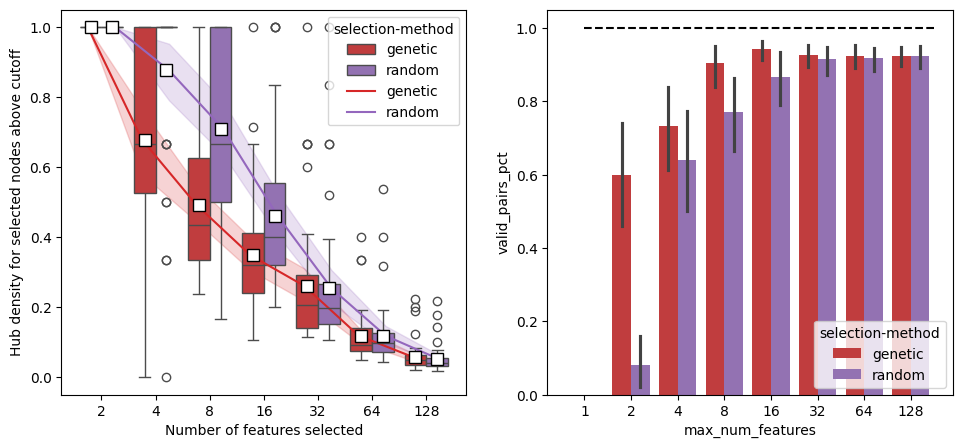

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=5*np.array([2.3, 1.]))
ax = sns.boxplot(
  data=hub_densities_df,
  x='max_num_features',
  y='hub_density',
  hue='selection-method',
  hue_order=['genetic', 'random'],
  palette=[palette[3], palette[4]],
  showmeans=True,
  meanprops={'marker':'s','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'},
  ax=axes[0],
)

sns.lineplot(
  data=hub_densities_df,
  x=pd.concat([
    np.log2(hub_densities_df[hub_densities_df['selection-method']=='genetic']['max_num_features'])-.25,
    np.log2(hub_densities_df[hub_densities_df['selection-method']=='random']['max_num_features'])+.25,
  ]),
  y='hub_density',
  hue='selection-method',
  ax=ax,
  palette=[palette[3], palette[4]],
  hue_order=['genetic', 'random'],
)

ax.set(ylabel='Hub density for selected nodes above cutoff', xlabel='Number of features selected')

g = sns.barplot(
  data=hub_densities_df,
  x='max_num_features',
  y='valid_pairs_pct',
  hue='selection-method',
  hue_order=['genetic', 'random'],
  palette=[palette[3], palette[4]],
  ax=axes[1],
)
g.legend_.set(loc='lower right')
g.hlines(1, 0, 7.5, colors='black', linestyles='--')

In [ ]:
combined_selected_df

,original_network_idx,max_num_features,node_idx,dist,above-cutoff?,selection_method
0,0,1,3748,0.12,False,random
1,1,1,4880,0.28,True,random
2,2,1,298,0.00,False,random
3,3,1,429,0.00,False,random
4,4,1,4604,0.26,True,random
...,...,...,...,...,...,...
11913,49,128,4807,0.14,False,genetic
11914,49,128,351,0.09,False,genetic
11915,49,128,3483,0.09,False,genetic
11916,49,128,3070,0.13,False,genetic


In [ ]:
degree_enriched_combined_selected_df = combined_selected_df.copy()
degree_enriched_combined_selected_df['in_degree'] = combined_selected_df.apply(
  lambda row: Gs[row.original_network_idx].in_degree(row.node_idx), axis=1
)
degree_enriched_combined_selected_df['out_degree'] = combined_selected_df.apply(
  lambda row: Gs[row.original_network_idx].out_degree(row.node_idx), axis=1
)
degree_enriched_combined_selected_df

,original_network_idx,max_num_features,node_idx,dist,above-cutoff?,selection_method,in_degree,out_degree
0,0,1,3748,0.12,False,random,8,1
1,1,1,4880,0.28,True,random,16,1
2,2,1,298,0.00,False,random,13,168
3,3,1,429,0.00,False,random,15,16
4,4,1,4604,0.26,True,random,5,1
...,...,...,...,...,...,...,...,...
11913,49,128,4807,0.14,False,genetic,10,5
11914,49,128,351,0.09,False,genetic,11,2
11915,49,128,3483,0.09,False,genetic,18,1
11916,49,128,3070,0.13,False,genetic,14,3


In [ ]:
degree_enriched_combined_selected_df[degree_enriched_combined_selected_df['selection_method'] == 'random'].out_degree.mean()

np.float64(13.109490196078431)

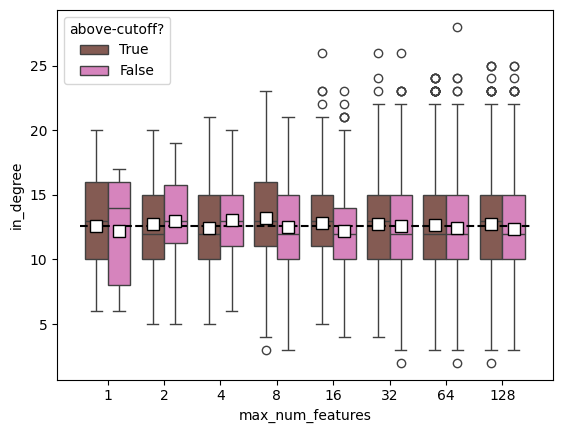

In [ ]:
palette = sns.color_palette('tab10', n_colors=7)
g = sns.boxplot(
  data=degree_enriched_combined_selected_df[degree_enriched_combined_selected_df['selection_method'] == 'genetic'],
  x='max_num_features',
  y='in_degree',
  hue='above-cutoff?',
  hue_order=[True, False],
  palette=[palette[5], palette[6]],
  showmeans=True,
  meanprops={'marker':'s','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'},
)

mean = degree_enriched_combined_selected_df[degree_enriched_combined_selected_df['selection_method'] == 'genetic']['in_degree'].mean()

g.hlines(mean, g.get_xlim()[0], g.get_xlim()[1], colors='black', linestyles='--', label='unconditional mean')


In [ ]:
def get_hub_num_above_cutoff_regulated(top: int = 10):
  data = []
  for selection_method in ['random', 'genetic']:
    for max_num_features in 2 ** np.arange(0, 8):
      _, activity_nodes = get_extracted_nodes(selection_method, max_num_features)
      for original_network_idx, G in enumerate(Gs):
        if original_network_idx not in activity_nodes.index: continue
        for hub in sorted([x for x in G.nodes()], key=lambda x: G.out_degree(x), reverse=True)[:top]:
          data.append({
            'original_network_idx': original_network_idx,
            'hub': hub,
            'max_num_features': max_num_features,
            'selection-method': selection_method,
            'pct-regulated': np.mean([
              G.has_edge(hub, node)
              for node in activity_nodes.loc[original_network_idx].node_idx
            ]),
          })

  hub_num_above_cutoff_regulated_df = pd.DataFrame(data)
  return hub_num_above_cutoff_regulated_df

In [ ]:
hub_num_above_cutoff_regulated_df = get_hub_num_above_cutoff_regulated()

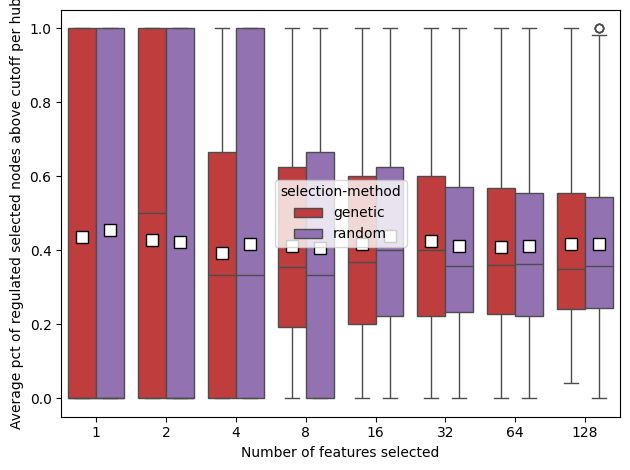

In [ ]:
g = sns.boxplot(
  data=hub_num_above_cutoff_regulated_df,
  x='max_num_features',
  y='pct-regulated',
  hue='selection-method',
  hue_order=['genetic', 'random'],
  palette=[palette[3], palette[4]],
  showmeans=True,
  meanprops={'marker':'s','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'},
)

g.set(
  xlabel='Number of features selected',
  ylabel='Average pct of regulated selected nodes above cutoff per hub',
)
plt.tight_layout()

In [ ]:
def get_corrs(extracted_nodes: any):
  cmap = sns.color_palette('vlag_r', as_cmap=True)
  df = states_df.copy()
  df = df.set_index(['drug_name', 'original_network_idx', 'initial_condition_idx'])
  corrs = (
    df.groupby('original_network_idx')
      .apply(lambda _df: (
        [C := _df[extracted_nodes.loc[_df.name]].corr().to_numpy(), C[np.tril_indices_from(C, k=-1)]][1]# .shape() #and
      )
    )
  )
  return corrs

In [ ]:
random_extracted_nodes, random_activity_nodes = get_extracted_nodes('random', 16)
genetic_extracted_nodes, genetic_activity_nodes = get_extracted_nodes('genetic', 16)

random_corrs = get_corrs(random_extracted_nodes)
genetic_corrs = get_corrs(genetic_extracted_nodes)

[Text(0.5, 1.0, 'random'), Text(0.5, 0, 'Correlation')]

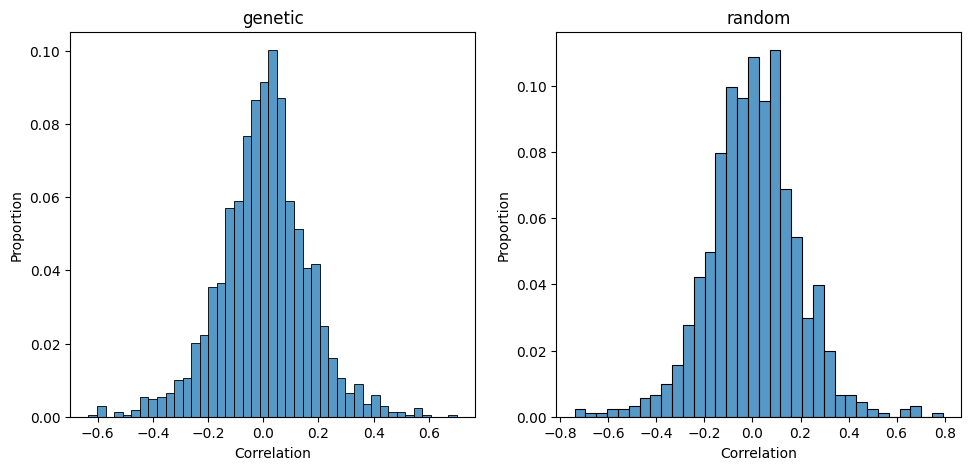

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=5*np.array([2.3, 1.]))
sns.histplot(pd.DataFrame(genetic_corrs.to_list()).melt(), x='value', stat='proportion', ax=axes[0]).set(title='genetic', xlabel='Correlation')
sns.histplot(pd.DataFrame(random_corrs.to_list()).melt(), x='value', stat='proportion', ax=axes[1]).set(title='random', xlabel='Correlation')

In [ ]:
data = []
for result in experiment.results:
  for perturbation in result.perturbations:
    for edge_perturbation in perturbation.edge_perturbations:
      data.append({
        'original_network_idx': result.network_idx,
        'name': perturbation.name,
        'source': edge_perturbation.source,
        'target': edge_perturbation.target,
        'delta': edge_perturbation.delta,
      })

perturbations_df = pd.DataFrame(data)
perturbations_df

,original_network_idx,name,source,target,delta
0,0,drug-1,877,1580,-0.727940
1,0,drug-1,877,3785,-0.971229
2,0,drug-1,2589,1091,-0.154079
3,0,drug-1,2589,2395,-1.089770
4,0,drug-1,2589,4021,0.643341
...,...,...,...,...,...
316244,49,drug-10,3786,3442,1.399605
316245,49,drug-10,3786,4359,0.040553
316246,49,drug-10,3786,4811,-1.348865
316247,49,drug-10,3786,4837,0.519815


In [ ]:
from collections import Counter
from functools import reduce
import operator

In [ ]:
pd.DataFrame((Counter([1, 2]) + Counter([2, 3])).items(), columns=['node', 'times_perturbed'])

,node,times_perturbed
0,1,1
1,2,2
2,3,1


In [ ]:
times_perturbed_df = (
  perturbations_df
    .groupby(['name', 'original_network_idx'])
    .apply(lambda _df: Counter(_df.source.unique()), include_groups=False)
    .reset_index(name='counter')
    .groupby('original_network_idx')['counter']
    .agg(lambda counters: reduce(operator.__add__, counters))
    .to_frame()
    .groupby('original_network_idx')
    .apply(
      lambda _df: pd.DataFrame(
        data=_df.counter.squeeze().items(),
        columns=['node', 'times_perturbed'],
      )
      .set_index('node')
    )
).reset_index()#.to_frame().loc['drug-1'][0].most_common()
times_perturbed_df

,original_network_idx,node,times_perturbed
0,0,877,2
1,0,2589,1
2,0,2139,2
3,0,3542,1
4,0,2057,1
...,...,...,...
23895,49,3298,1
23896,49,3706,1
23897,49,1694,1
23898,49,3811,1


In [ ]:
combined_above_cutoff_df = combined_selected_df[combined_selected_df['above-cutoff?']].drop(columns=['dist', 'above-cutoff?']).set_index(['original_network_idx', 'node_idx'])
combined_above_cutoff_df

max_num_features selection_method
original_network_idx node_idx                                   
1                    4880                     1           random
4                    4604                     1           random
6                    843                      1           random
12                   2691                     1           random
13                   3920                     1           random
...                                         ...              ...
49                   2484                   128          genetic
                     1287                   128          genetic
                     2062                   128          genetic
                     3539                   128          genetic
                     2254                   128          genetic

[10525 rows x 2 columns]

In [ ]:
hits_df = (
  times_perturbed_df
    .groupby(['original_network_idx', 'node'])
    .apply(lambda _df:
      (special_nodes := combined_above_cutoff_df.loc[_df.name[0]]).assign(
        has_edge=lambda row: Gs[_df.name[0]].has_edge(_df.name[1], row.index.values[0]),
        times_perturbed=_df.times_perturbed.squeeze(),
      ),
      include_groups=False,
    )
    .reset_index()
    .rename(columns={
      'node': 'perturbed_node',
      'node_idx': 'selected_above_cutoff_node',
    })
)
hits_df

,original_network_idx,perturbed_node,selected_above_cutoff_node,max_num_features,selection_method,has_edge,times_perturbed
0,0,3,344,4,random,False,1
1,0,3,2903,4,random,False,1
2,0,3,2035,8,random,False,1
3,0,3,682,8,random,False,1
4,0,3,597,16,random,False,1
...,...,...,...,...,...,...,...
5030740,49,4990,2484,128,genetic,False,1
5030741,49,4990,1287,128,genetic,False,1
5030742,49,4990,2062,128,genetic,False,1
5030743,49,4990,3539,128,genetic,False,1


In [ ]:
num_controlled_df = (
  hits_df
    .groupby(['original_network_idx', 'perturbed_node', 'max_num_features', 'selection_method'])
    .apply(lambda _df: _df.has_edge.sum(), include_groups=False)
    .reset_index(name='num_selected_nodes_above_cutoff_controlled_by_perturbed_node')
)
num_controlled_df

,original_network_idx,perturbed_node,max_num_features,selection_method,num_selected_nodes_above_cutoff_controlled_by_perturbed_node
0,0,3,1,genetic,0
1,0,3,2,genetic,0
2,0,3,4,genetic,0
3,0,3,4,random,0
4,0,3,8,genetic,0
...,...,...,...,...,...
344130,49,4990,32,random,0
344131,49,4990,64,genetic,0
344132,49,4990,64,random,0
344133,49,4990,128,genetic,0


In [ ]:
num_controlling_df = (
  hits_df
    .groupby(['original_network_idx', 'selected_above_cutoff_node', 'max_num_features', 'selection_method'])
    .apply(lambda _df: _df.has_edge.sum(), include_groups=False)
    .reset_index(name='num_perturbed_nodes_controlling_selected_nodes_above_cutoff_controlled')
)
num_controlling_df

,original_network_idx,selected_above_cutoff_node,max_num_features,selection_method,num_perturbed_nodes_controlling_selected_nodes_above_cutoff_controlled
0,0,31,64,random,0
1,0,67,128,random,0
2,0,98,128,genetic,0
3,0,109,16,random,0
4,0,113,32,genetic,0
...,...,...,...,...,...
10520,49,4852,128,genetic,2
10521,49,4887,128,random,2
10522,49,4895,128,genetic,2
10523,49,4933,64,genetic,2


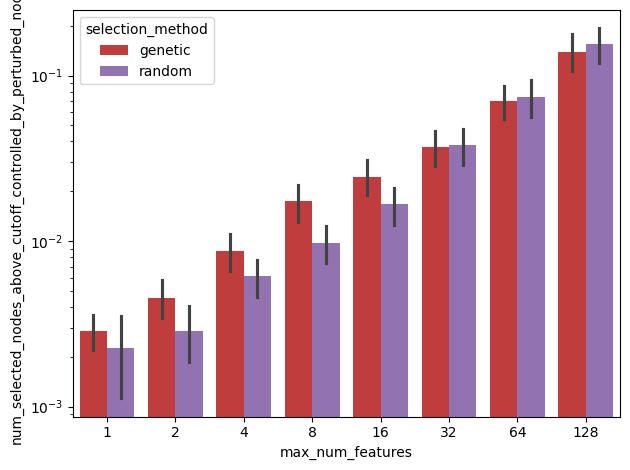

In [ ]:
sns.barplot(
  data=num_controlled_df,
  x='max_num_features',
  y=num_controlled_df['num_selected_nodes_above_cutoff_controlled_by_perturbed_node'],
  hue='selection_method',
  hue_order=['genetic', 'random'],
  palette=[palette[3], palette[4]],
).set(yscale='log')
plt.tight_layout()

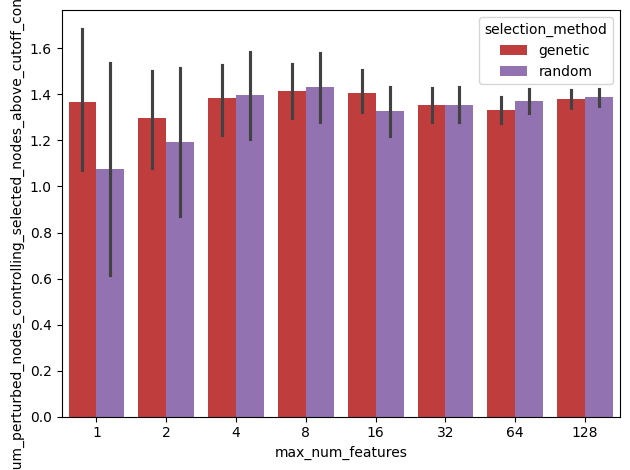

In [ ]:
sns.barplot(
  data=num_controlling_df,
  x='max_num_features',
  y='num_perturbed_nodes_controlling_selected_nodes_above_cutoff_controlled',
  hue='selection_method',
  hue_order=['genetic', 'random'],
  palette=[palette[3], palette[4]],
)
plt.tight_layout()

In [ ]:
# melted_df = controls_mat.reset_index().melt(
#   id_vars=['original_network_idx', 'initial_condition_idx', 'rep'],
#   var_name='node',
#   value_name='activity',
# )
# melted_df = melted_df.set_index(['original_network_idx', 'initial_condition_idx', 'rep'])
# melted_df

In [ ]:
# sns.lineplot(
#   data=melted_df[melted_df.loc[:,:,0].activity == 0],
#   x='rep',
#   y='activity',
# )